In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from astroquery.sdss import SDSS
from matplotlib.pyplot import GridSpec
import scipy
from scipy.interpolate import interp1d

In [2]:
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below  
# from specutils import Spectrum1D
# from specutils import SpectralRegion
# from specutils.analysis import equivalent_width
# import warnings
# from specutils.fitting import fit_generic_continuum

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fac286a2550>

In [5]:
def tran_func(x):  #function for calibrating spectrum value numbers
    return x**2/115

In [112]:
def spec_an(wl_file, proj_file, comp_vals, nudge):   #this compares the spectra
                                                        #it also creates a nice comparison plot
    specv = pd.read_table(proj_file, sep="\s+")
    specv['inv_fl'] = -specv['val'] + max(specv['val'])    #opens projection data
        
    wlkey = pd.read_csv(wl_file)      #reads wavelength calibration info

    def wlcalib3(x,a,b,c,d):
        return a*x**3+b*x**2+c*x+d

    popt, pcov = curve_fit(wlcalib3, wlkey['pix'], wlkey['wl'])    #uses above function to wl calibrate
    specv['wl'] = wlcalib3(specv['pix'] + nudge, *popt)

    fig = plt.figure(constrained_layout=True, figsize=(10, 7))    #unimportant plotting stuff
    gs = GridSpec(3, 3, figure=fig)

    fig.suptitle("Balmer Series Spectrum Comparison", fontsize=15)

    ax1 = fig.add_subplot(gs[0, -0])
    ax2 = fig.add_subplot(gs[0, -2])
    ax3 = fig.add_subplot(gs[0, -1])
    ax4 = fig.add_subplot(gs[1, :])

    wl_data = np.linspace(4000,6800,np.shape(datie)[0])
    ax1.set_xlim(4050, 4151)
    #ax1.set_ylim(10,57)
    ax1.plot(specv['wl'], comp_vals(specv['inv_fl']), color = 'cornflowerblue', alpha = 0.7, label = 'Plate Spectrum')
    #ax1.plot(10**sdssdf['loglam'], sdssdf['flux']*1500, color = 'salmon', alpha = 0.7, label = 'Sample Spectrum')
    ax1.plot(wl_data, datie, color = 'darkorange', alpha = 0.7, label = 'Sample Spectrum')
    
    ax2.set_xlim(4289, 4389)
    #ax2.set_ylim(10,53)
    ax2.plot(specv['wl'], comp_vals(specv['inv_fl']), color = 'cornflowerblue', alpha = 0.7, label = 'Plate Spectrum')
    #ax2.plot(10**sdssdf['loglam'], sdssdf['flux']*1500, color = 'salmon', alpha = 0.7, label = 'Sample Spectrum')
    ax2.plot(wl_data, datie, color = 'darkorange', alpha = 0.7, label = 'Sample Spectrum')

    ax3.set_xlim(4810, 4910)
    #ax3.set_ylim(10,60)
    ax3.plot(specv['wl'], comp_vals(specv['inv_fl']), color = 'cornflowerblue', alpha = 0.7, label = 'Plate Spectrum')
    #ax3.plot(10**sdssdf['loglam'], sdssdf['flux']*1500, color = 'salmon', alpha = 0.7, label = 'Sample Spectrum')
    ax3.plot(wl_data, datie, color = 'darkorange', alpha = 0.7, label = 'Sample Spectrum')

    ax4.set_xlim(np.min(specv['wl'])-10, np.max(specv['wl'])+10)
    #ax4.set_ylim(-1,65)
    ax4.plot(specv['wl'], comp_vals(specv['inv_fl']), color = 'cornflowerblue', alpha = 0.7, label = 'Plate Spectrum')
    #ax4.plot(10**sdssdf['loglam'], sdssdf['flux']*1500, color = 'salmon', alpha = 0.7, label = 'Sample Spectrum')
    ax4.plot(wl_data, datie, color = 'darkorange', alpha = 0.7, label = 'Sample Spectrum')
    ax4.axvline(x = 4101, color = 'plum', alpha = 0.4)
    ax4.axvline(x = 4861, color = 'plum', alpha = 0.4)
    ax4.axvline(x = 4339, color = 'plum', alpha = 0.4)

    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left", prop={'size': 6.8}, bbox_to_anchor=(0.05,0.72))

    plt.xlabel(r'Wavelength ($Å$)', linespacing=3)
    plt.ylabel(r'Flux ($erg/sec \cdot cm^2 \cdot Å$)', linespacing=3)

    #plt.figure(figsize=(20,30))
    #plt.savefig('/Users/irescapa/Desktop/resid_linsub_balm_ser.pdf', bbox_inches = 'tight')
    plt.show()
    return(specv, datie, popt)

In [24]:
def spectra_centroid(table_path, pix_arg, val_arg):
    
    calib_line = pd.read_table(table_path, sep="\s+")
    
    def gauss(x, H, A, x0, sigma):    #gauss function for fitting
        return (H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))

    just_nvals = np.where(calib_line[val_arg] < (np.max(calib_line[val_arg]) -np.std(calib_line[val_arg])), calib_line[val_arg], 0)
    just_pixs = np.where(calib_line[val_arg] < (np.max(calib_line[val_arg]) -np.std(calib_line[val_arg])), calib_line[pix_arg], 0)
    # ^ gets all vals above std
    valnpix = [[],[]]
    for lists in [[just_nvals,0], [just_pixs,1]]:
        size = len(lists[0])
        idx_list = [idx for idx, val in
                    enumerate(lists[0]) if val == 0]

        sult = [lists[0][i+1: j] for i, j in
                zip([0] + idx_list, idx_list +
                ([size] if idx_list[-1] != size else []))]

        valnpix[lists[1]] = [x for x in sult if x != []]   #^ makes these into sets of lists
    cent_val = []
    for i in range(0, np.shape(valnpix)[1]):
        if np.shape(valnpix[0][i])[0] > 3:
            popt, pcov = curve_fit(gauss, valnpix[0][i], valnpix[1][i]) #matches each list to find centroid
            cent_val.append(popt[0])
        else:
            pass
        
    return(cent_val)

In [21]:
def normalizer(spectrum, sample, perbins):
    spec_min, spec_max, sam_min, sam_max = np.min(spectrum['wl']), np.max(spectrum['wl']), np.min(sample['wl']), np.max(sample['wl'])
    if spec_min > sam_min: #minning the wl values
        world_min_sa = np.min(np.where(sample['wl'] > spec_min))
        world_min_sp = np.min(np.where(spectrum['wl'] > spec_min))
        
    else:  
        world_min_sa = np.min(np.where(sample['wl'] > sam_min))
        world_min_sp = np.min(np.where(spectrum['wl'] > sam_min))
        
    if spec_max > sam_max:
        world_max_sa = np.max(np.where(sample['wl'] < sam_max))
        world_max_sp = np.max(np.where(spectrum['wl'] < sam_max))
    else:
        world_max_sa = np.max(np.where(sample['wl'] < spec_max))
        world_max_sp = np.max(np.where(spectrum['wl'] < spec_max))
    #makes sure the two spectra have data for overlapping regions
        
    spec_wl = np.array(spectrum['wl'])[world_min_sp:world_max_sp]
    sam_wl = np.array(sample['wl'])[world_min_sa:world_max_sa]
    spec_val = np.array(spectrum['inv_fl'])[world_min_sp:world_max_sp]
    sam_val = np.array(sample['data'])[world_min_sa:world_max_sa]
    
    sp_specwl = np.array_split(spec_wl, perbins)
    sp_specval = np.array_split(spec_val, perbins)
    sp_samwl = np.array_split(sam_wl, perbins)
    sp_samval = np.array_split(sam_val, perbins)
    
    sp_specwl = np.insert(sp_specwl, 0, [spec_wl[0]])
    sp_specwl = np.insert(sp_specwl, -1, [spec_wl[-1]])
    sp_specval = np.insert(sp_specval, 0, [spec_val[0]])
    sp_specval = np.insert(sp_specval, -1, [spec_val[-1]])
    
    sp_samwl = np.insert(sp_samwl, 0, [sam_wl[0]])
    sp_samwl = np.insert(sp_samwl, -1, [sam_wl[-1]])
    sp_samval = np.insert(sp_samval, 0, [sam_val[0]])
    sp_samval = np.insert(sp_samval, -1, [sam_val[-1]])
    
    av_spval = np.arange(perbins+2)
    av_saval = np.arange(perbins+2)
    av_spwl = np.arange(perbins+2)
    av_sawl = np.arange(perbins+2)
    
    #finding average vales for spline-fitting (trying to do in for-loops in annother version of this function)
    for i in range(perbins+2):
        av_spval[i] = np.mean(sp_specval[i])
        av_saval[i] = np.mean(sp_samval[i])
        av_spwl[i] = np.mean(sp_specwl[i])
        av_sawl[i] = np.mean(sp_samwl[i])
    
    
    samespec = av_spval - av_saval
    spec_spline = scipy.interpolate.interp1d(av_spwl, samespec,kind = 'quadratic', fill_value="extrapolate")
    #gives a corrected result and the spline used to create it
    return((spec_val-spec_spline(spec_wl)), spec_wl)
    

In [147]:
hdu1 = fits.open('elodie_19970918_0042.fits')
datie = hdu1[0].data
header = hdu1[0].header
shap = np.shape(datie)[0]    #this is opening an elodie spectrum


In [113]:
samp = pd.DataFrame({'wl': np.linspace(4000,6800, np.shape(datie)[0]), 'data': datie})
#giving elodie wavelength data

In [17]:
reci, reci2 = normalizer(plspe, samp, 300)

In [70]:
xxies = spectra_centroid('1B556_lines.dat', 'Pix', 'val')

/var/folders/c0/bxk1h7r54tb6c3hllk8gs7nr0000gn/T/ipykernel_11753/330828493.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  valnpix[lists[1]] = [x for x in sult if x != []]
/var/folders/c0/bxk1h7r54tb6c3hllk8gs7nr0000gn/T/ipykernel_11753/330828493.py:21: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  valnpix[lists[1]] = [x for x in sult if x != []]
/Users/irescapa/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/Users/irescapa/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpac

In [51]:
def wlcalib3(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d

In [47]:
specv = pd.read_table('1B556_1200_proj.dat', sep="\s+")
specv['inv_fl'] = -specv['val'] + max(specv['val'])

(200000.0, 1400000.0)

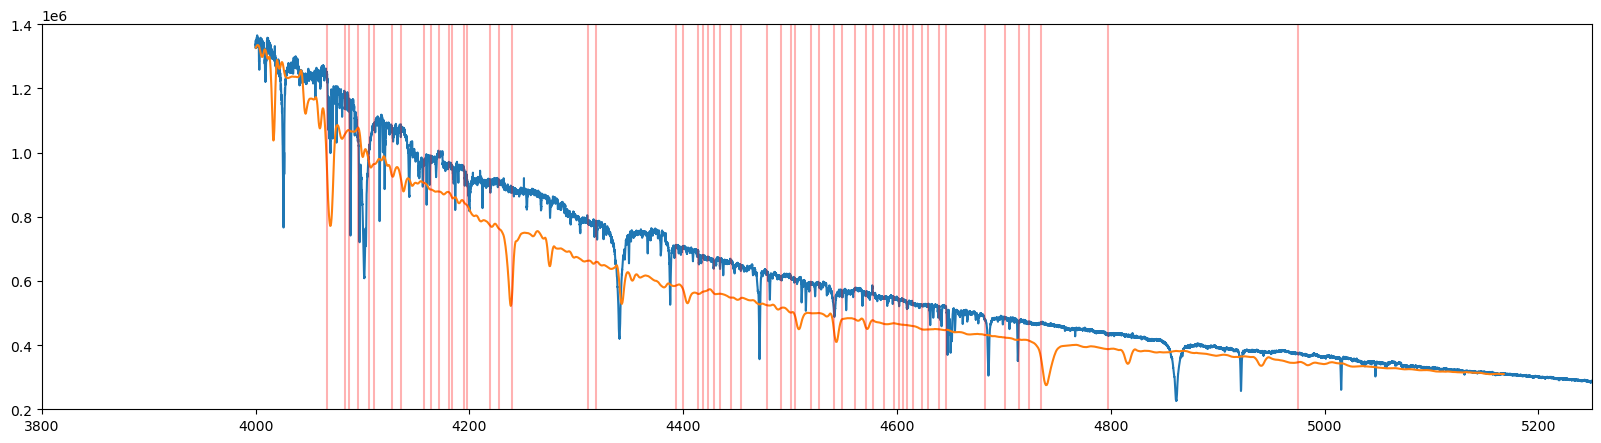

In [145]:
plt.figure(figsize = (20,5))
plt.plot(samp['wl'], samp['data'])
plt.plot(reci2, reci)
plt.vlines(wlcalib3(np.array(xxies)+100, *int_val)+300, 0.2e6, 1.4e6, color = 'r', alpha = 0.3)
plt.xlim(3800, 5250)
plt.ylim(0.2e6, 1.4e6)

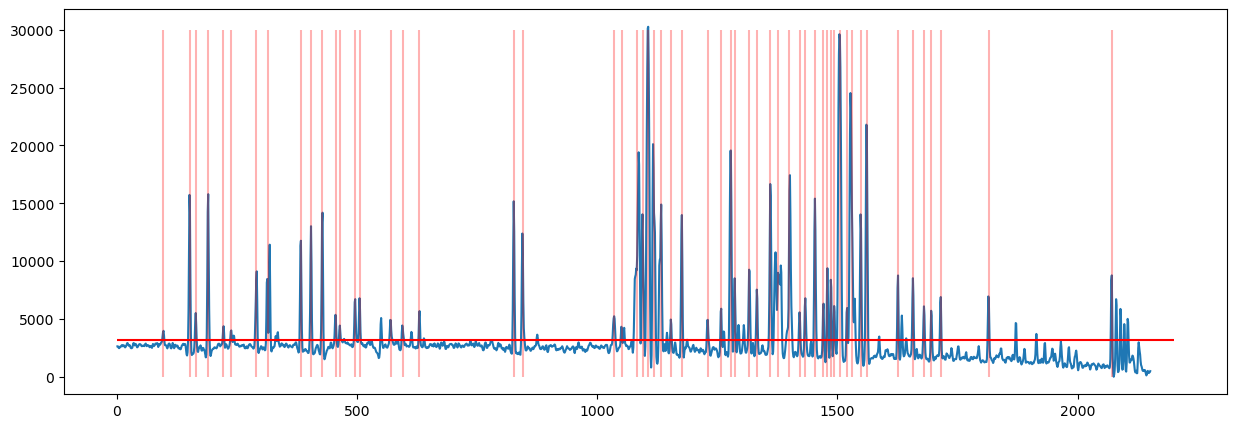

In [120]:
plt.figure(figsize = (15,5))
plt.plot(np.array(liners['Pix']), -liners['val']+np.max(liners['val']))
plt.hlines(np.mean(-liners['val']+np.max(liners['val'])), 0, 2200, color = 'r')
plt.vlines(np.array(xxies), 0, 30000, color = 'r', alpha = 0.3)
plt.show()

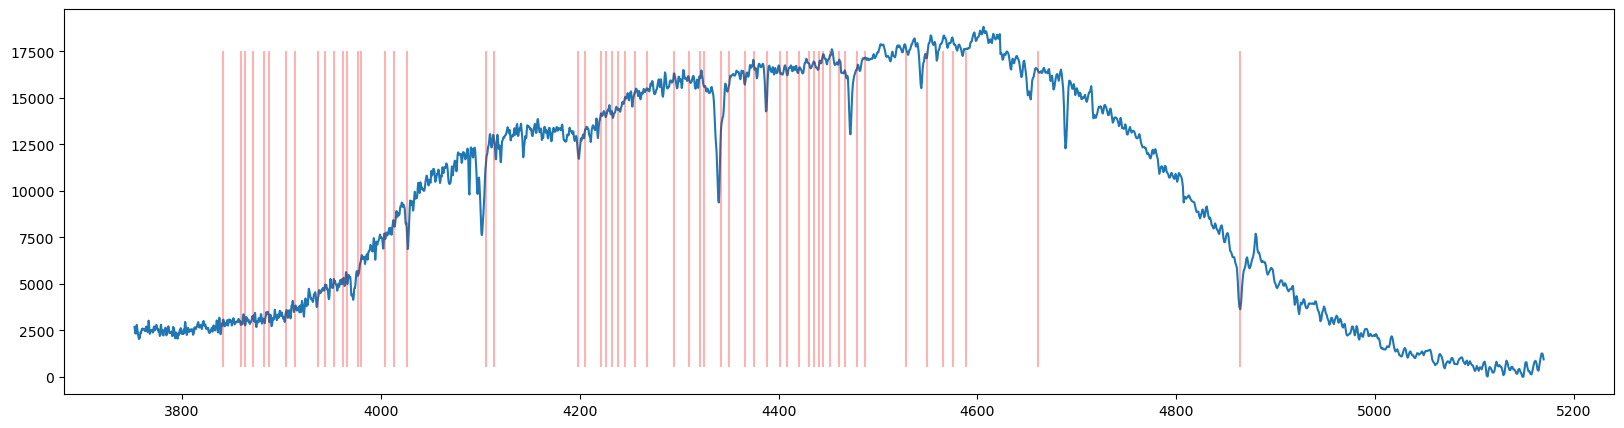

In [111]:
plt.figure(figsize = (20,5))
plt.plot(plspe['wl'], plspe['inv_fl'])
plt.vlines(wlcalib3(np.array(xxies)+337, *int_val), 500, 17500, color = 'r', alpha = 0.3)

/Users/irescapa/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


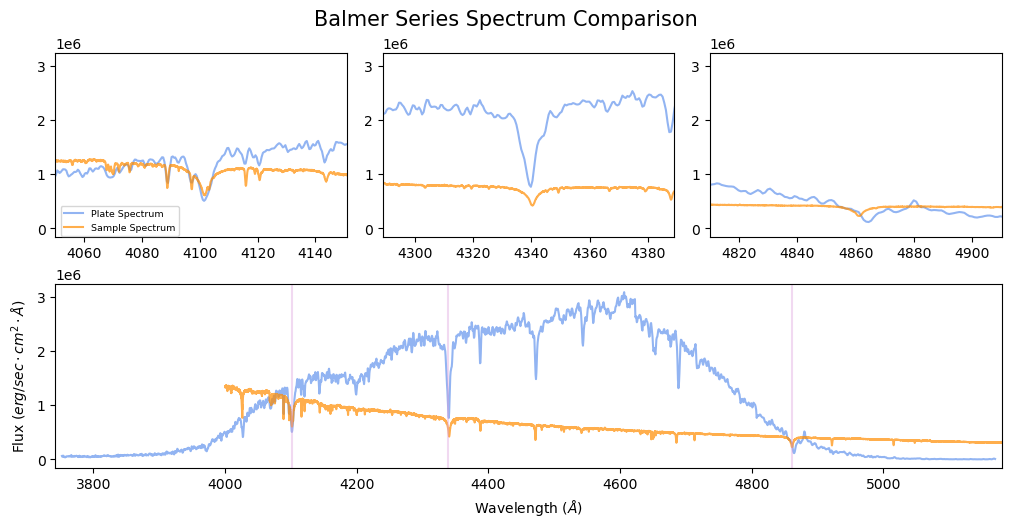

In [49]:
plspe, elodi, int_val = spec_an('file path to/1B556_1200.csv','file path to/1B556_1200_proj.dat', tran_func, 150)#-10)


In [43]:
def hdcomp(down_bound, up_bound):     #herter-dreffield diagram, compares specific Å at peaks and stuff
    elode_sm = elode['data'][elode['wl'] > down_bound][elode['wl'] < up_bound]

    spev_sm = plspe['inv_fl'][plspe['wl'] > down_bound][plspe['wl'] < up_bound]
    spev_sm=(spev_sm**2)/115
    
    wanted = []
    split = 2
    spl_so = np.array_split(elode_sm, len(spev_sm))
    for arr in range(0, len(spev_sm)):
        migval = np.mean(spl_so[arr])
        #s_vau = np.mean(spl_so[arr][1])
        wanted.append(migval)
        
    fig,(ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
    ax1.scatter(spev_sm, wanted)
    ax2.plot(np.linspace(down_bound, up_bound, len(spev_sm)), wanted)
    ax2.plot(np.linspace(down_bound, up_bound, len(spev_sm)), spev_sm)
    
    plt.savefig('vides_1.pdf')
    
    plt.show()

## you can ignore stuff below here, i was just playing around with a spectra analysis library and other things

In [4]:
def sdss_spec_df(datafile_name):   #this opens sdss spectra and puts them into a similar format
    hdu = fits.open(datafile_name)       #as the data we get from DS9
    data = hdu[1].datafile_name            #you don't have to worry about this right now
    
    big_dat = []
    for i in range(0,len(data)):
        row_dat = []
        for j in range(0,8):
            row_dat.append(data[i][j])
        big_dat.append(row_dat)

    sdsspec = pd.DataFrame(big_dat)

    sdsspec['flux'] = sdsspec[0]
    sdsspec['loglam'] = sdsspec[1]
    sdsspec['ivar'] = sdsspec[2]
    sdsspec['and_mask'] = sdsspec[3]
    sdsspec['or_mask'] = sdsspec[4]
    sdsspec['wdisp'] = sdsspec[5]
    sdsspec['sky'] = sdsspec[6]
    sdsspec['model'] = sdsspec[7]
    sdsspec['wl'] = 10**sdsspec['loglam']
    for i in range(0,8):
        sdsspec.drop(i, inplace=True, axis=1)
    return(sdsspec)

sdssdf = sdss_spec_df('/Users/irescapa/Downloads/spec-1240-52734-0421.fits')

In [3]:
spec_type = 'A0'   #sdss sample spectrum retrival
query = "SELECT TOP 10 p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, s.subClass,s.specobjid,s.snMedian,s.plate,s.mjd,s.fiberid FROM PhotoObj AS p JOIN SpecObj AS s ON s.bestobjid = p.objid WHERE snMedian > 30. and s.Class = 'STAR' and s.subCLass = '{}' and p.u < 19. and p.z < 19.0".format(spec_type)
res = SDSS.query_sql(query)
sp = SDSS.get_spectra(SkyCoord(res['ra'][0], res['dec'][0], unit = 'deg'))



/Users/irescapa/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [49]:
spec = Spectrum1D(spectral_axis = np.array(plspe['wl'])*u.AA, flux = (np.array(plspe['inv_fl'])* 10**-17 * u.Unit('erg cm-2 s-1 AA-1')))

NameError: name 'Spectrum1D' is not defined

In [50]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    cont_norm_spec = spec / fit_generic_continuum(spec)(spec.spectral_axis) 
equivalent_width(cont_norm_spec, regions=SpectralRegion(4325 * u.AA, 4341 * u.AA)) 

NameError: name 'warnings' is not defined

In [48]:
np.array(plspe['wl'])*1e-17*u.Unit('erg cm-2 s-1 AA-1')

<Quantity [3.75211282e-14, 3.75242620e-14, 3.75273959e-14, ...,
           5.16753433e-14, 5.16855550e-14, 5.16957721e-14] erg / (Angstrom cm2 s)>

In [31]:
equivalent_width(cont_norm_spec, regions=SpectralRegion(4099 * u.AA, 4105 * u.AA)) 

<Quantity 1.22241292 Angstrom>

In [32]:
equivalent_width(cont_norm_spec, regions=SpectralRegion(4331 * u.AA, 4348 * u.AA)) 

<Quantity 2.1608201 Angstrom>

In [33]:
equivalent_width(cont_norm_spec, regions=SpectralRegion(4855 * u.AA, 4866 * u.AA)) 

<Quantity 4.96241982 Angstrom>

In [51]:
from __future__ import division
from numpy import abs, sum, linspace
from numpy.fft import rfft

spectrum = abs(rfft(specv['inv_fl']))
normalized_spectrum = spectrum / sum(spectrum)  # like a probability mass function
normalized_frequencies = linspace(0, 1, len(spectrum))
spectral_centroid = sum(normalized_frequencies * normalized_spectrum)

# Spectral centroid is calculated as a ratio.  Multiply by your maximum frequency bin to get real frequency.

In [52]:
spectral_centroid

0.05991380520827263

In [53]:
normalized_spectrum

array([4.08760102e-01, 1.69252606e-01, 3.98417947e-02, ...,
       4.83887568e-06, 2.92633024e-05, 3.04009366e-05])

(0.0, 0.05)

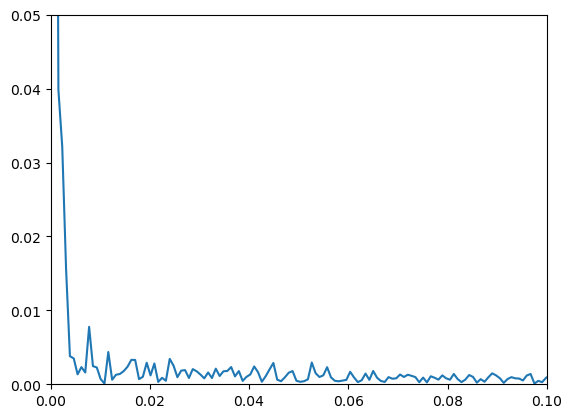

In [55]:
plt.plot(normalized_frequencies, normalized_spectrum)
plt.xlim(0,0.1)
plt.ylim(0,0.05)